In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.linear_model import LinearRegression

df_original = pd.read_excel('data-5features-all-outputs.xlsx')
df_all = pd.read_excel('All_data_correct.xlsx')
df_all.drop(columns=["Responsibility", "Listening_skills", "Questioning_skills", "Team_participation", "Teamwork_oriented"], inplace=True)
df = df_original.iloc[:,2:]

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import Normalizer

normalizer = Normalizer(norm='l1')
# I have selected the other 4 outputs variables to predict the final target, team climate.
target = df.iloc[:,-1:]
variables = df.iloc[:,5:9]
all_personality = df_all.iloc[:,9:44]
team_climate = df_all.iloc[:,-1:]
bigfive = df.iloc[:, :5]

# Normalisation of the data??
normalized_bigfive = (bigfive - bigfive.min())/(bigfive.max()-bigfive.min())
normalized_target = (target - target.min())/(target.max()-target.min())

big_five_names = list(df.columns[:5])

Random Forest to predict the team climate based on the rest output variables

In [56]:
X_train, X_test, y_train, y_test = train_test_split(normalized_bigfive, np.ravel(normalized_target), test_size=0.2, random_state=42)

# rft = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=9, random_state=42)
rft = RandomForestRegressor(random_state=42)
rft.fit(X_train, y_train)
y_pred = rft.predict(X_test)
score = rft.score(X_test, y_test)
score

0.06321913760468612

In [7]:
rft_importances = pd.Series(rft.feature_importances_, index=list(variables)).sort_values()
rft_importances

Vision                    0.078844
Support_for_innovation    0.161815
Task_Orientation          0.260488
Participative_safety      0.498853
dtype: float64

We can see that the attribute Participative_safety has the most influence in predicting the team climate in the model

In [66]:
team_ids = df_all['Team ID'].unique()
# The team ids are splitted into training and testing
train_teams, test_teams = train_test_split(team_ids, test_size=0.2)
# The dataset is separated
train_df = df_all[df_all['Team ID'].isin(train_teams)]
test_df = df_all[df_all['Team ID'].isin(test_teams)]

In [67]:
aux = train_df.iloc[:, 9:].drop(big_five_names, axis=1)
all_personality = list(aux.iloc[:, :30])
target = 'Team_Climate'
all_targets = list(aux.iloc[:, 30:34])

X_train_s = train_df[big_five_names]
X_train_a = train_df[all_personality]
X_test_s = test_df[big_five_names]
X_test_a = test_df[all_personality]
y_train_s = train_df[target]
y_train_a = train_df[target]
y_test_s = test_df[target]
y_test_a = test_df[target]

In [68]:
X_train_s

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
0,57,96,29,73,80
1,3,75,26,84,36
2,72,94,98,10,40
3,70,68,79,53,58
4,80,18,18,56,13
...,...,...,...,...,...
267,50,75,68,56,9
268,2,1,1,19,1
269,57,23,77,27,59
280,27,57,61,50,32


In [69]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15]
}
dtr = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_s)
# mse = mean_squared_error(y_test_s, y_pred)
# rmse = mse ** 0.5
best_params = grid_search.best_params_
test_score = best_estimator.score(X_test_s, y_test_s)
print(f"Best params: {best_params}")
print(f"Test score: {test_score}")
# print(f"RMSE: {rmse}")


Best params: {'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 2}
Test score: -0.14314418669335538


In [71]:
y_pred

array([4.01426087, 3.65161905, 3.846     , 3.8004    , 3.65161905,
       3.65161905, 3.8004    , 4.00118182, 3.65161905, 3.846     ,
       3.44519231, 4.36966667, 3.44519231, 4.08371429, 4.36966667,
       3.44519231, 3.65161905, 4.16294118, 4.43713636, 3.8004    ,
       3.44519231, 4.01426087, 3.44519231, 4.43713636, 4.16294118,
       4.08371429, 4.01426087, 3.65161905, 4.08371429, 3.44519231,
       4.16294118, 4.16294118, 4.43713636, 3.44519231, 4.08371429,
       3.44519231, 4.00118182, 4.00118182, 3.65161905, 3.846     ,
       3.44519231, 4.01426087, 4.36966667, 3.44519231, 4.43713636,
       4.08371429, 4.36966667, 3.65161905, 3.846     , 3.44519231,
       3.44519231, 3.44519231, 4.43713636, 3.846     ])

In [72]:
dtr = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=20, random_state=42)
dtr.fit(X_train_s, y_train_s)
y_pred = dtr.predict(X_test_s)
# print(accuracy_score(y_test_s, y_pred))
dtr.score(X_test_s, y_test_s)

0.049245056071083204

In [73]:
y_test_s

10     4.026
13     3.684
14     3.316
15     3.842
16     3.974
45     4.240
46     2.270
52     3.770
66     3.320
67     3.930
71     4.330
73     4.470
74     3.330
79     3.870
83     3.470
86     3.820
88     3.970
100    2.130
104    3.950
106    3.670
116    3.490
117    3.890
120    3.920
124    4.970
130    4.680
132    2.710
133    4.130
136    4.130
139    4.840
140    4.390
145    3.920
147    3.500
150    3.320
152    3.630
156    3.260
158    3.000
230    4.770
231    4.570
232    3.800
233    4.430
234    3.750
235    3.990
236    4.150
237    4.260
270    4.140
271    4.610
272    4.560
273    5.000
274    3.270
275    3.730
276    3.750
277    4.010
278    4.610
279    3.770
Name: Team_Climate, dtype: float64

In [59]:
y_pred = pd.Series(y_pred)
y_pred

0     0.642618
1     0.676523
2     0.688293
3     0.823181
4     0.665336
5     0.767566
6     0.762167
7     0.646621
8     0.669552
9     0.796083
10    0.605316
11    0.652635
12    0.692092
13    0.701244
14    0.638756
15    0.627425
16    0.704601
17    0.727402
18    0.697693
19    0.606235
20    0.700394
21    0.649968
22    0.648555
23    0.844365
24    0.711513
25    0.903957
26    0.791336
27    0.830066
28    0.713011
29    0.751256
30    0.764075
31    0.718083
32    0.716741
33    0.824414
34    0.709009
35    0.646943
36    0.650483
37    0.721011
38    0.739490
39    0.745786
40    0.685244
41    0.740517
42    0.593043
43    0.671017
44    0.492911
45    0.877144
46    0.696606
47    0.657388
48    0.884713
49    0.635060
50    0.713375
51    0.763348
52    0.682713
53    0.660578
54    0.622293
55    0.681598
56    0.677960
dtype: float64

In [15]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_s, y_train_s)
predictions = neigh.predict(X_test_s)
neigh.score(X_test_s, y_test_s)

0.1695197842850349

In [16]:
predictions

array([3.8066, 3.674 , 4.2492, 4.1787, 3.9104, 3.868 , 3.81  , 4.106 ,
       4.3254, 3.8852, 4.2311, 3.7317, 3.6801, 4.158 , 3.9493, 3.8815,
       4.0669, 3.8744, 4.1231, 3.6281, 4.045 , 4.019 , 3.7528, 3.5976,
       4.0224, 3.8729, 3.9237, 3.6798, 4.0738, 4.1613, 3.7557, 3.6609,
       3.7105, 3.8288, 4.1476, 4.2852, 3.8121, 4.1825, 4.1198, 4.1304,
       4.0414, 3.9137, 3.921 , 4.105 , 3.7758, 3.9641, 3.5953])

In [17]:
gbc = GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=1, random_state=42).fit(X_train_s, y_train_s)
gbc.score(X_test_s, y_test_s)


-0.04417864330701149

In [22]:
clf = LinearRegression()
clf.fit(X_train_s, y_train_s)
clf.score(X_test_s, y_test_s)

0.03090905973532765

# Normalisation of the dataset? (Both input and output features)
# Negative values in the score of the ML models
# Is there any problem in the train test split process?

Better understanding of the possible error, data visualisation, dimensionality reduction to visualise the difficulty of learning a function that predicts well.
Create several training and testing split and get the average to get a better estimation of the performance.

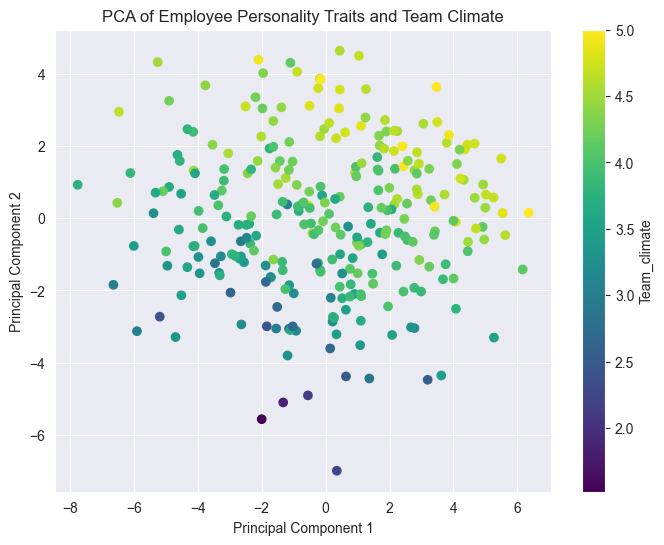

<Figure size 640x480 with 0 Axes>

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df_pca = df_all.iloc[:, 9:]
target = df_pca['Team_Climate']
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df_pca))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Team_Climate'] = target.values

plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Team_Climate'], cmap='viridis')
plt.colorbar(scatter, label='Team_climate')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Employee Personality Traits and Team Climate')
plt.show()
plt.savefig('PCA.png')